# Model Testing

Here we will test different models to see which one performs best on our data. We will test different models:


We will work on already prepared dataset.

In [1]:
import pandas as pd
import data_preprocessing as dp

jobs_df = pd.read_csv('data/cleared/linkedin_data.csv')

# Dropping unnecessary columns
jobs_df = jobs_df.drop(['Job_Desc', 'Job_Ttl', 'max_sal', 'min_sal', 'Co_Nm', 'py_prd', 'loc'], axis=1)

jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Flw_Cnt        12491 non-null  int64  
 1   Is_Supvsr      12491 non-null  bool   
 2   med_sal        12491 non-null  float64
 3   wrk_typ        12491 non-null  object 
 4   st_code        12491 non-null  object 
 5   is_remote      12491 non-null  int64  
 6   views          12491 non-null  int64  
 7   xp_lvl         12491 non-null  object 
 8   mean_year_sal  12491 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 793.0+ KB


### Data Preparation


In [2]:
mean_sal_by_xp_lvl = jobs_df.groupby('xp_lvl')['med_sal'].mean()

mean_sal_by_st_code = jobs_df.groupby('st_code')['med_sal'].mean()

mean_sal_by_wrk_type = jobs_df.groupby('wrk_typ')['med_sal'].mean() 

jobs_df['mean_sal_by_st_code'] = jobs_df['st_code'].map(mean_sal_by_st_code)

jobs_df['mean_sal_by_xp_lvl'] = jobs_df['xp_lvl'].map(mean_sal_by_xp_lvl)

jobs_df['mean_sal_by_wrk_type'] = jobs_df['wrk_typ'].map(mean_sal_by_wrk_type)

jobs_df_copy = jobs_df.copy()
jobs_df_copy = jobs_df_copy.drop(['st_code'], axis=1)

y = jobs_df['med_sal'].values
X = jobs_df[['Flw_Cnt', 'Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_xp_lvl', 'mean_sal_by_xp_lvl', 'mean_sal_by_wrk_type']].values

## K Neighbors Regressor

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

regressor = KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=2)
regressor.fit(X_train_scaled, y_train_scaled)

y_pred = regressor.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.flatten()


scores = cross_val_score(regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']

param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric_options)

grid = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

grid.fit(X_train_scaled, y_train_scaled.ravel())

print(f" RMSE: {np.sqrt(-grid.best_score_)}")
print(f" Best parameters: {grid.best_params_}")
print(f" Best estimator: {grid.best_estimator_}")



# Use the best estimator from the grid search to make predictions
best_regressor = grid.best_estimator_
y_pred_best = best_regressor.predict(X_test_scaled)

# Reshape y_pred_best to a 2D array and inverse transform
y_pred_best = y_pred_best.reshape(-1, 1)
y_pred_best = scaler.inverse_transform(y_pred_best)
y_pred_best = y_pred_best.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse)}")
print(f"R-squared Score (R2): {r2}")

 RMSE: 0.8218383255843076
 Best parameters: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'uniform'}
 Best estimator: KNeighborsRegressor(metric='manhattan', n_neighbors=30)
Mean Absolute Error (MAE): 26798.39753687693
Mean Squared Error (MSE): 1190768322.2776873
Root Mean Squared Error (RMSE): 34507.51109943583
R-squared Score (R2): 0.3119075444426287


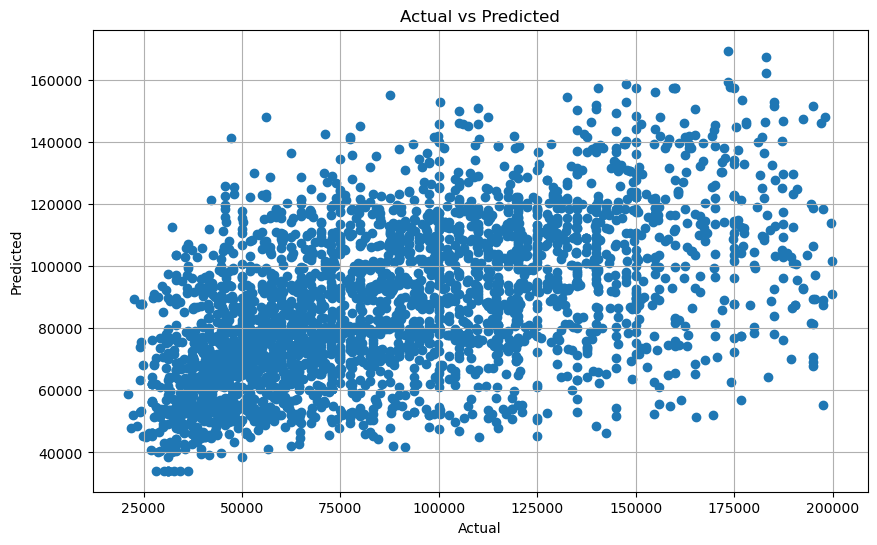

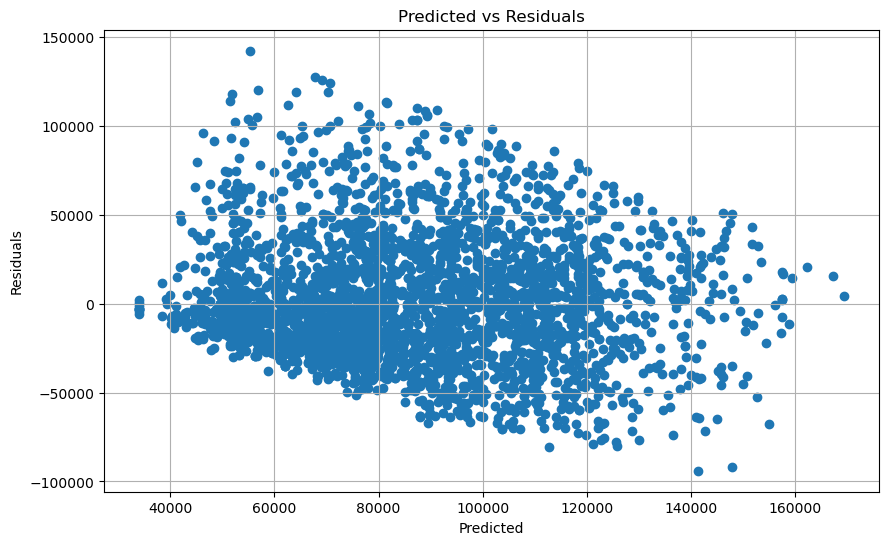

In [4]:
import matplotlib.pyplot as plt

# Use the best estimator from the grid search to make predictions
best_regressor = grid.best_estimator_
y_pred_best = best_regressor.predict(X_test_scaled)

# Reshape y_pred_best to a 2D array
y_pred_best = y_pred_best.reshape(-1, 1)

y_pred_best = scaler.inverse_transform(y_pred_best)
y_pred_best = y_pred_best.flatten()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, y_test - y_pred_best)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.grid(True)
plt.show()

The provided Python code is performing a regression task using a K-Nearest Neighbors (KNN) model to predict median salaries based on several job features. The code includes data preprocessing (such as feature scaling and splitting the data into training and testing sets), model training, prediction, and evaluation using Mean Squared Error (MSE) and cross-validation.

## Comments on the results

The evaluation metrics you've calculated provide a mixed picture of your model's performance:

1. **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual values is approximately 26798. This means that on average, model's predictions are about $26798 off from the actual values.

2. **Root Mean Squared Error (RMSE):** The RMSE is approximately 34508, which is higher than the MAE. This indicates that your model has made some predictions that are significantly off from the actual values, as the RMSE is more sensitive to large errors.

3. **R-squared Score (R2):** The R2 score is approximately 0.312, which means that about 31.2% of the variability in the target variable can be explained by the model. This isn't a very high R2 score, suggesting that the model doesn't explain a large portion of the variability in the data.



# Decision Tree Regression

In [5]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [None, 2, 5, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
}

regressor = DecisionTreeRegressor(random_state=0)

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

print('Best parameters: ', grid_search.best_params_)

best_regressor = grid_search.best_estimator_

y_pred = best_regressor.predict(X_test_scaled)
print('Mean squared error: ', mean_squared_error(y_test, y_pred))

scores = cross_val_score(best_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print('RMSE scores: ', rmse_scores)
print('Mean RMSE: ', rmse_scores.mean())
print('Standard deviation of RMSE: ', rmse_scores.std())
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mean squared error:  1956303384.9641244
RMSE scores:  [36010.05730438 35275.48931742 34753.30498571 35707.52178799
 35365.19922337]
Mean RMSE:  35422.314523774454
Standard deviation of RMSE:  424.07035276927616
MAE: 38067.06571033937


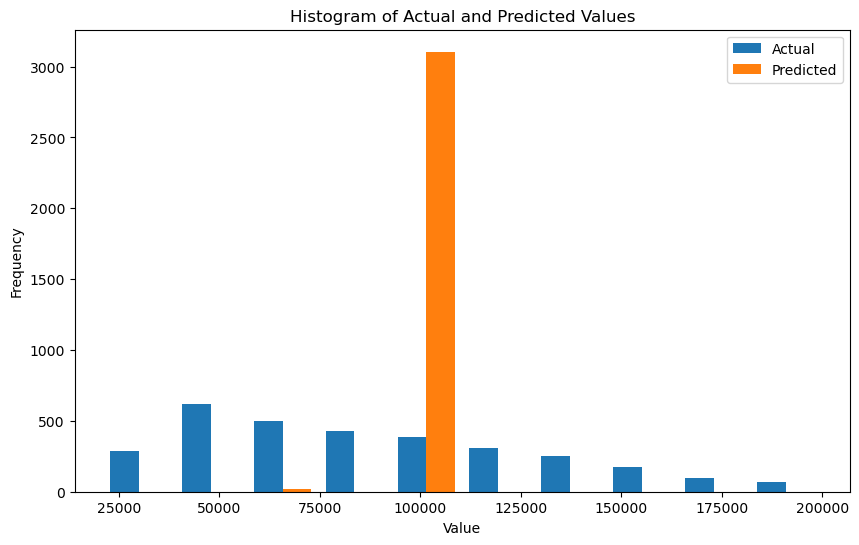

In [6]:
plt.figure(figsize=(10, 6))
plt.hist([y_test, y_pred], label=['Actual', 'Predicted'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Actual and Predicted Values')
plt.legend()
plt.show()

### Comments on the results

1. **Mean Squared Error (MSE):** The MSE is approximately 1956303384.96, which is quite high. This indicates that the model's predictions are, on average, far off from the actual values.

2. **Root Mean Squared Error (RMSE):** The mean RMSE from cross-validation is approximately 35422.31, with a standard deviation of 424.07. This suggests that the model's performance is fairly consistent across different subsets of the data.

3. **Mean Absolute Error (MAE):** The MAE is approximately 38067.07. This means that on average, your model's predictions are about $38067 off from the actual values.

The best parameters found by the grid search are a maximum depth of 5, a minimum samples leaf of 2, and a minimum samples split of 5.

Overall, these metrics suggest that the Decision Tree model is not performing very well on this dataset. The errors are quite high, indicating that the model's predictions are often far off from the actual values. You might consider trying a different type of model, adding more features if they are available, or further tuning the model's parameters.
Also the plot shows that the model is not performing well.

# Support Vector Regression

Mean Absolute Error (MAE): 26993.836174679298
Mean Squared Error (MSE): 1257974284.4045708
Root Mean Squared Error (RMSE): 35467.93318484418
R-squared Score (R2): 0.27307218525241417


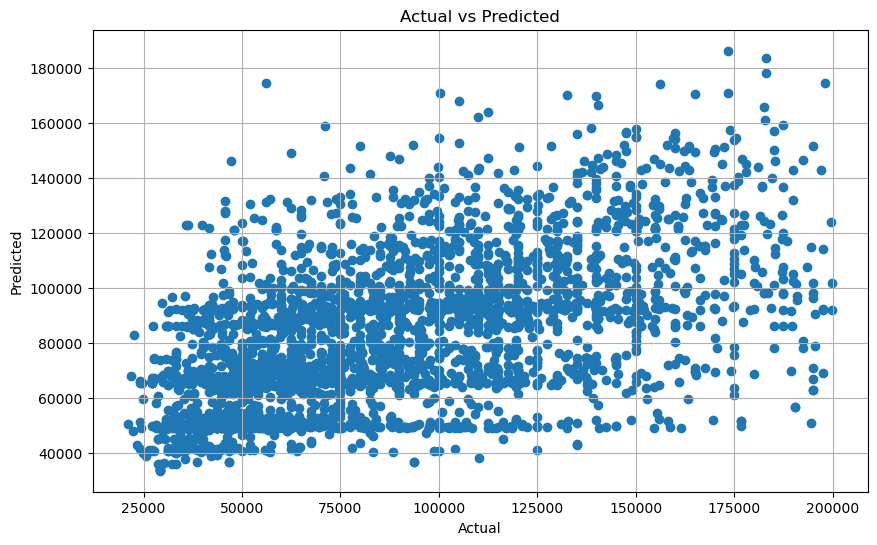

In [7]:
from sklearn.svm import SVR

# Define the model
svr = SVR(kernel='rbf')

# Fit the model
svr.fit(X_train_scaled, y_train_scaled.ravel())

# Use the model to make predictions
y_pred_svr = svr.predict(X_test_scaled)

# Reshape y_pred_svr to a 2D array and inverse transform
y_pred_svr = y_pred_svr.reshape(-1, 1)
y_pred_svr = scaler.inverse_transform(y_pred_svr)
y_pred_svr = y_pred_svr.flatten()

# Calculate metrics
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Mean Absolute Error (MAE): {mae_svr}")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_svr)}")
print(f"R-squared Score (R2): {r2_svr}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

## Comments on the results

The metrics you've posted are used to evaluate the performance of your regression model:

1. **Mean Absolute Error (MAE)**: This is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were. The measure gives an idea of the magnitude of the error, but no idea of the direction (i.e. over or under predicting). In your case, the MAE is approximately 26993.84.

2. **Mean Squared Error (MSE)**: This is the average of the squared differences between the predicted and actual values. This is a popular metric because squaring the errors penalizes larger errors more than smaller ones. Your MSE is approximately 1257974284.40.

3. **Root Mean Squared Error (RMSE)**: This is the square root of the MSE. Taking the square root of the MSE converts the units back to the original units of the output variable, which can be useful for interpretation. Your RMSE is approximately 35467.93.

4. **R-squared (R2)**: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The higher the R-squared, the better the model fits your data. Your R2 score is approximately 0.273, which means about 27.3% of the variance in your target variable can be explained by your features.

Given these metrics, it seems like the model could be improved, as the errors are quite high and the R2 score is relatively low.


# Random Forest Regression

Mean Absolute Error (MAE): 87839.75130252328
Mean Squared Error (MSE): 9446327303.359375
Root Mean Squared Error (RMSE): 97192.21832718592
R-squared Score (R2): -4.4586156085628605


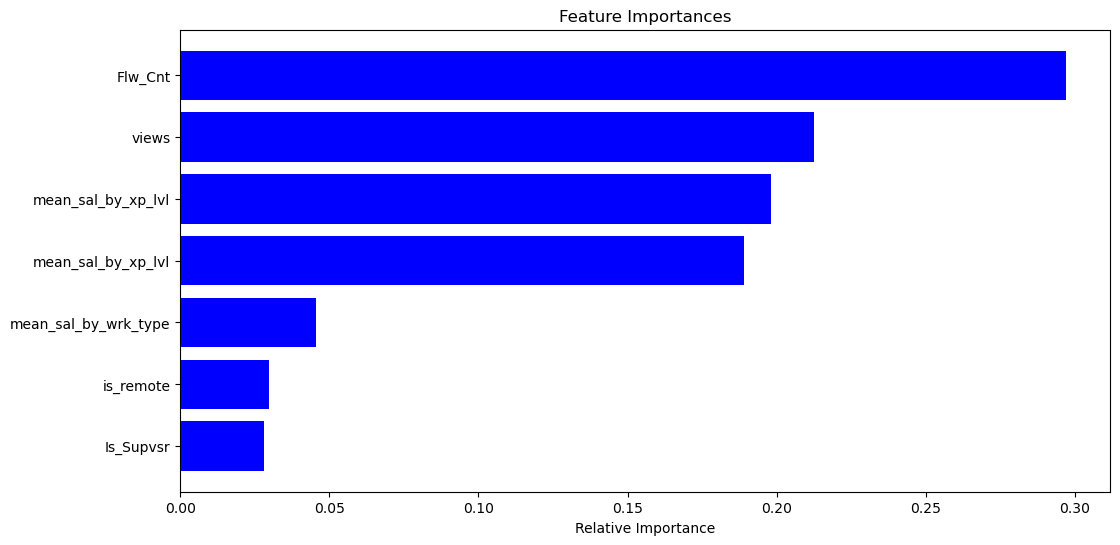

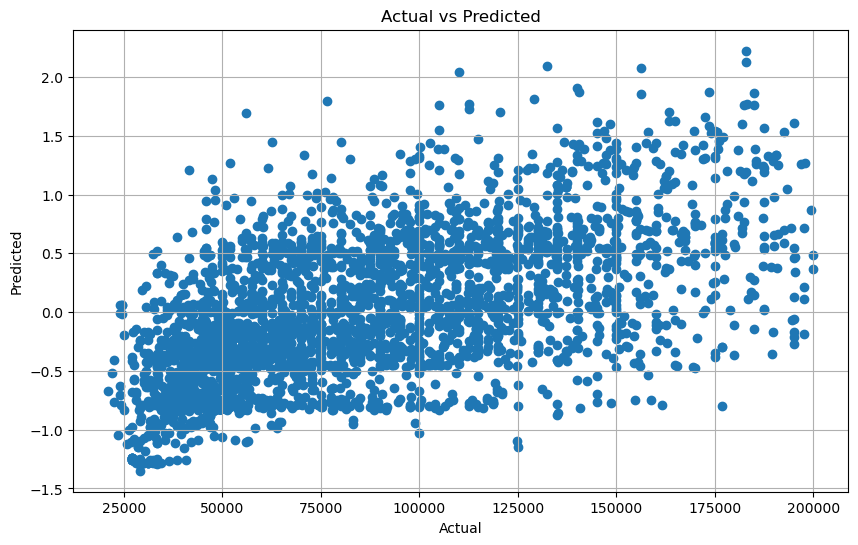

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor()

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_rf = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Calculate metrics
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Mean Absolute Error (MAE): {mae_best_rf}")
print(f"Mean Squared Error (MSE): {mse_best_rf}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_best_rf)}")
print(f"R-squared Score (R2): {r2_best_rf}")

# Plot feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)

features = ['Flw_Cnt', 'Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_xp_lvl', 'mean_sal_by_xp_lvl', 'mean_sal_by_wrk_type']

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Comments on the results

1. **Mean Absolute Error (MAE)**: This is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were. The measure gives an idea of the magnitude of the error, but no idea of the direction (i.e. over or under predicting). In your case, the MAE is approximately 87839.75.

2. **Mean Squared Error (MSE)**: This is the average of the squared differences between the predicted and actual values. This is a popular metric because squaring the errors penalizes larger errors more than smaller ones. Your MSE is approximately 9446327847.33.

3. **Root Mean Squared Error (RMSE)**: This is the square root of the MSE. Taking the square root of the MSE converts the units back to the original units of the output variable, which can be useful for interpretation. Your RMSE is approximately 97192.22.

4. **R-squared (R2)**: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The higher the R-squared, the better the model fits your data. Your R2 score is approximately -4.46, which is unusual as R2 score typically ranges from 0 to 1. A negative R2 score may indicate that your model is performing worse than a horizontal line (i.e., a very simple model).

Given these metrics, it seems like the model is not performing well. The errors are quite high and the R2 score is negative.

# Gradient Boosting Regression

Mean Absolute Error (MAE): 87839.75595863332
Mean Squared Error (MSE): 9446323907.305609
Root Mean Squared Error (RMSE): 97192.2008563733
R-squared Score (R2): -4.4586136461332835


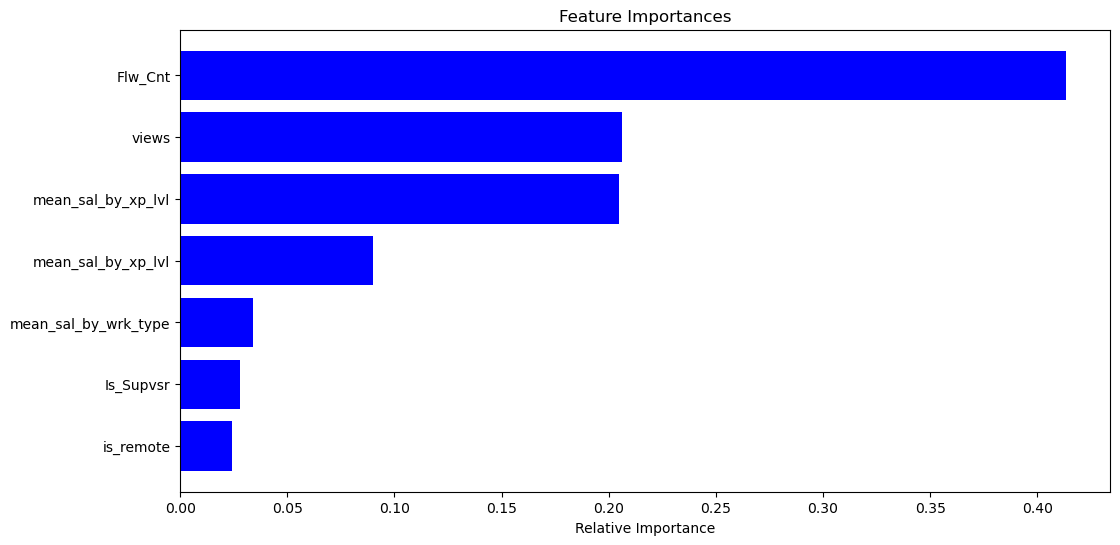

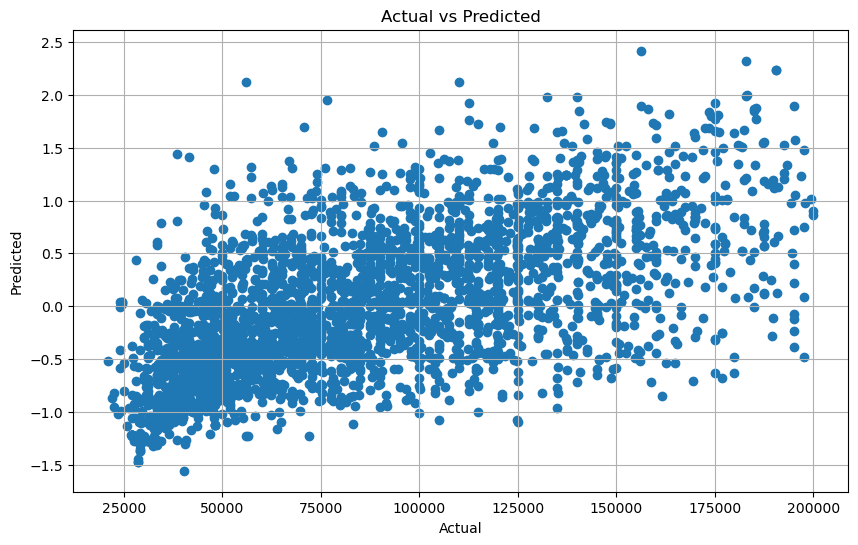

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the model
gb = GradientBoostingRegressor()

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_gb = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_best_gb = best_gb.predict(X_test_scaled)

# Calculate metrics
mae_best_gb = mean_absolute_error(y_test, y_pred_best_gb)
mse_best_gb = mean_squared_error(y_test, y_pred_best_gb)
r2_best_gb = r2_score(y_test, y_pred_best_gb)

print(f"Mean Absolute Error (MAE): {mae_best_gb}")
print(f"Mean Squared Error (MSE): {mse_best_gb}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_best_gb)}")
print(f"R-squared Score (R2): {r2_best_gb}")

# Plot feature importance
importances = best_gb.feature_importances_
indices = np.argsort(importances)

features = ['Flw_Cnt', 'Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_xp_lvl', 'mean_sal_by_xp_lvl', 'mean_sal_by_wrk_type']

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_gb)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

## Comments on the results

The metrics provided offer insights into the performance of the Gradient Boosting Regressor model. Each metric serves a distinct purpose in evaluating the model's predictive accuracy:

1. **Mean Absolute Error (MAE):** This metric, with a value of approximately 87839.76, gauges the average absolute discrepancies between predicted and actual values. It signifies the magnitude of errors but doesn't provide directional information.

2. **Mean Squared Error (MSE):** With an approximate value of 9446323907.31, MSE computes the average of squared differences, emphasizing larger errors. This metric is commonly used for its sensitivity to outliers.

3. **Root Mean Squared Error (RMSE):** At around 97192.20, RMSE, derived from the square root of MSE, facilitates interpretation in the original output variable units. It offers a sense of the average magnitude of errors.

4. **R-squared (R2):** The R2 score, oddly registering at approximately -4.46, reflects the proportion of variance in the dependent variable explained by the model. The negative R2 score is unusual, as it typically ranges from 0 to 1. A negative score suggests potential underperformance, possibly worse than a simplistic horizontal line model.

Considering these metrics collectively, there are indications that the Gradient Boosting Regressor model may not be delivering optimal results. High errors and a negative R2 score prompt considerations for alternative models, feature augmentation, or parameter tuning to enhance overall model performance.
